# Load dataset

I use the same dataset here as in the exploratory analysis (with the Fourier features).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import MDS
from tqdm.auto import tqdm
from torchsummary import summary

In [2]:
# Fix seed
SEED = 2020
# used by torch:
random.seed(SEED)
torch.manual_seed(SEED)
# used by np/sklearn:
np.random.seed(SEED)

In [3]:
INPUT_SIZE = (2, 128)  # (number of channels, number of timepoints)
EMBEDDING_SIZE = 20    # size of the resulting embedding vector
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
from gaitkeeper.idnet import load_idnet_dataset
from gaitkeeper import preprocess
from gaitkeeper.models import GaitDataset, EmbeddingNet, ClassificationNet, extract_embeddings, train_epoch, test_epoch

In [5]:
idnet, uid_to_label = load_idnet_dataset(INPUT_SIZE[1], INPUT_SIZE[1], "within")

Loading IDNet dataset...


In [6]:
idnet[0].head()

,index,user_id,walk_id,timestamp,accelerometer_x_data,accelerometer_y_data,accelerometer_z_data,gravity_x_data,gravity_y_data,gravity_z_data,...,gyroscope_y_data,gyroscope_z_data,linearaccelerometer_x_data,linearaccelerometer_y_data,linearaccelerometer_z_data,rotvec_x_data,rotvec_y_data,rotvec_z_data,linearaccelerometer_mag,gyroscope_mag
0,0,0,1,00:00:00,11.429413,13.207573,-2.905304,8.098272,3.164553,4.535816,...,0.680824,0.402073,3.057558,9.447635,-6.760017,0.126302,-0.502773,-0.107802,0.107486,-1.750423
1,1,0,1,00:00:00.020000,14.402929,13.907359,-5.801336,8.096599,3.164967,4.538527,...,0.277962,0.698341,6.505161,10.540532,-10.212775,0.131064,-0.501419,-0.099810,0.225041,-1.861075
2,2,0,1,00:00:00.040000,15.532158,9.432022,-6.550606,8.158741,3.147670,4.437870,...,-1.251019,0.172699,7.431986,8.858565,-11.362463,0.133393,-0.505898,-0.093894,0.229633,-1.420654
3,3,0,1,00:00:00.060000,16.256038,6.215317,-1.636937,8.341006,3.252337,3.996294,...,-3.279388,-1.063980,7.744561,3.826707,-7.994730,0.137464,-0.526555,-0.097377,0.100432,0.801073
4,4,0,1,00:00:00.080000,13.252632,3.881683,6.037125,8.560603,3.534127,3.217793,...,-5.011791,-1.596348,6.169664,0.914308,1.414185,0.144371,-0.561271,-0.113427,-0.055925,2.633095


In [7]:
# Split dataset into a training and validation by-user
# (Test dataset will simulate new users)
train_users = list(uid_to_label.values())[:25]
test_users = list(uid_to_label.values())[25:]

In [8]:
# Split separate walk sessions
train = []
test = []
for chunk in idnet:
    if chunk.iloc[0]["user_id"] in train_users:
        train.append(chunk)
    else:
        test.append(chunk)

train_dataset = GaitDataset(train)
test_dataset = GaitDataset(test, train=False)

In [9]:
# Since we train the embedding from the classification network, further split the training data into sub-training/sub-validation
# This is needed for accuracy metrics and to know when to stop training (due to overfitting)
train_classification, test_classification = train_test_split(train, test_size=0.1)
train_dataset_classification = GaitDataset(train_classification)
test_dataset_classification = GaitDataset(test_classification)

## Model setup

In [10]:
# Set up data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
train_loader_classification = torch.utils.data.DataLoader(train_dataset_classification, batch_size=batch_size, shuffle=True)
test_loader_classification = torch.utils.data.DataLoader(test_dataset_classification, batch_size=batch_size, shuffle=False)

In [12]:
embedding_net = EmbeddingNet(EMBEDDING_SIZE)
n_classes = len(uid_to_label)
model = ClassificationNet(embedding_net, n_classes=n_classes).to(DEVICE)

In [13]:
criterion = torch.nn.NLLLoss()
lr = 5e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 15

In [14]:
summary(model, INPUT_SIZE)  # Verify model is valid shaped

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 128]             176
              ReLU-2              [-1, 16, 128]               0
            Conv1d-3              [-1, 32, 128]           2,592
              ReLU-4              [-1, 32, 128]               0
         MaxPool1d-5               [-1, 32, 64]               0
            Conv1d-6               [-1, 64, 64]           6,592
              ReLU-7               [-1, 64, 64]               0
            Conv1d-8               [-1, 64, 64]          12,352
              ReLU-9               [-1, 64, 64]               0
        MaxPool1d-10               [-1, 64, 32]               0
          Flatten-11                 [-1, 2048]               0
           Linear-12                   [-1, 20]          40,980
     EmbeddingNet-13                   [-1, 20]               0
             ReLU-14                   

In [15]:
for epoch in tqdm(range(n_epochs), desc="Epoch"):
    train_loss, train_acc = train_epoch(train_loader_classification, model, criterion, optimizer, DEVICE)
    scheduler.step()  # update learning rate (decrease)
    print(f"[{epoch+1}/{n_epochs}]   Training:   loss = {train_loss:.6f} / acc = {train_acc:.6f}")
    valid_loss, valid_acc = test_epoch(test_loader_classification, model, criterion, DEVICE)
    print(f"[{epoch+1}/{n_epochs}]   Validation: loss = {valid_loss:.6f} / acc = {valid_acc:.6f}")

[1/15]   Training:   loss = 1.692017 / acc = 0.345740
[1/15]   Validation: loss = 1.390115 / acc = 0.487040
[2/15]   Training:   loss = 0.359630 / acc = 0.603017
[2/15]   Validation: loss = 1.185956 / acc = 0.635061
[3/15]   Training:   loss = 0.673907 / acc = 0.697241
[3/15]   Validation: loss = 0.826031 / acc = 0.680082
[4/15]   Training:   loss = 0.499578 / acc = 0.736204
[4/15]   Validation: loss = 0.657360 / acc = 0.736698
[5/15]   Training:   loss = 1.236710 / acc = 0.742950
[5/15]   Validation: loss = 0.744510 / acc = 0.729195
[6/15]   Training:   loss = 0.748153 / acc = 0.737644
[6/15]   Validation: loss = 0.529440 / acc = 0.738063
[7/15]   Training:   loss = 0.248667 / acc = 0.750076
[7/15]   Validation: loss = 0.507428 / acc = 0.741473
[8/15]   Training:   loss = 0.754778 / acc = 0.757959
[8/15]   Validation: loss = 0.484506 / acc = 0.730559
[9/15]   Training:   loss = 0.553872 / acc = 0.768951
[9/15]   Validation: loss = 0.468873 / acc = 0.727149
[10/15]   Training:   loss =

## Evaluate embeddings

In [16]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, embedding_net)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, embedding_net)

In [17]:
def aggregate_similarities_mean(simi):
    # Fill in diagonals so they don't affect the aggregation
    np.fill_diagonal(simi.values, np.nan)
    pool = simi.groupby(simi.index, axis=0).mean().groupby(simi.columns, axis=1).mean()
    return pool

In [18]:
def plot_heatmap(embeddings, labels, dist_method="euclidean", agg=True):
    embeddings_df = pd.DataFrame(embeddings, index=labels.astype(int)).sort_index()
    if dist_method == "euclidean":
        similarity = euclidean_distances(embeddings_df.values, embeddings_df.values)
    elif dist_method == "cosine":
        similarity = cosine_similarity(embeddings_df.values, embeddings_df.values)
    similarity_df = pd.DataFrame(similarity, index=embeddings_df.index, columns=embeddings_df.index)
    f, ax = plt.subplots(figsize=(15,15))
    if agg:
        similarity_df = aggregate_similarities_mean(similarity_df)
    sns.heatmap(similarity_df, square=True, ax=ax, cmap="viridis")
    return similarity_df

In [19]:
def plot_embeddings_mds(embeddings, labels, metric="euclidean"):
    if metric == "euclidean":
        mds = MDS()
        embeddings_mds = mds.fit_transform(embeddings)
    elif metric == "cosine":
        # Need to precompute cosine distances
        mds = MDS(dissimilarity="precomputed")
        embeddings_mds = cosine_similarity(embedding, embeddings)
    f, ax = plt.subplots(figsize=(15, 15))
    sns.scatterplot(x=embeddings_mds[:,0], y=embeddings_mds[:,1], 
                    hue="user=" + pd.Series(labels).astype(int).astype(str),
                    ax=ax)
    ax.set_xlabel("MDS-1")
    ax.set_ylabel("MDS-2")
    ax.set_title("Multidimensional scaling representation")
    return mds  # Return because they take so long to generate

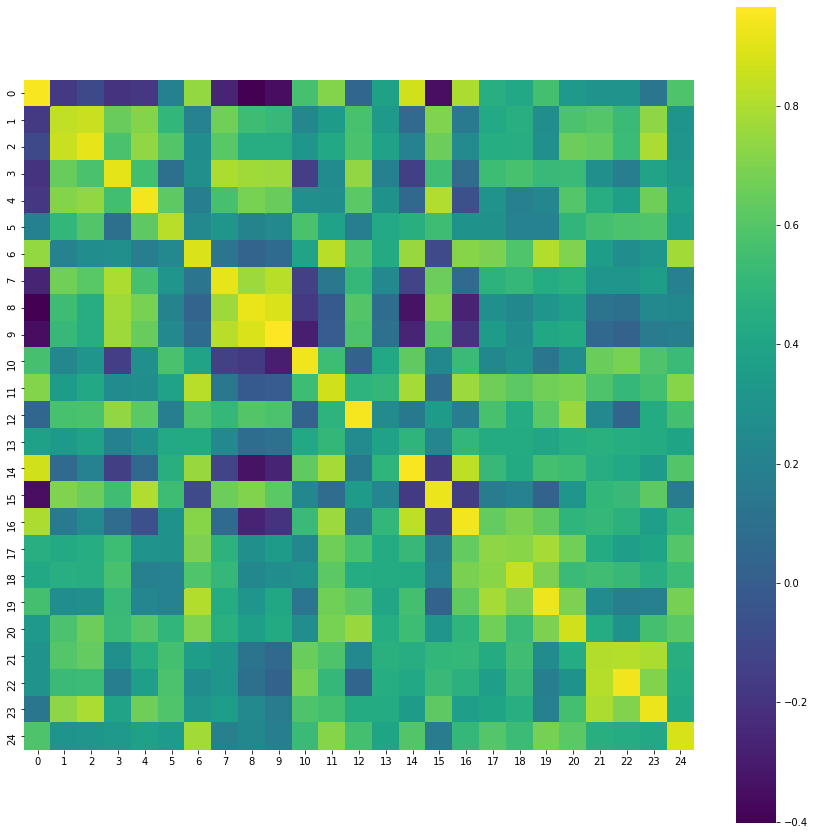

In [20]:
simi_train = plot_heatmap(train_embeddings_baseline, train_labels_baseline, dist_method="cosine")

In [21]:
def intra_vs_inter_avg_similarity(simi_mat):
    # Average within diagonal
    intra = np.diag(simi_mat).mean()
    # Average outside of diagonal
    # Get indices of upper-triangle and average
    iu, ju = np.triu_indices_from(simi_mat, k=1)
    inter = np.mean([simi_mat[i,j] for i, j in zip(iu, ju)])
    return intra, inter

In [22]:
# Plot average similarity within same-user vs between different users
intra_vs_inter_avg_similarity(simi_train.values)

(0.8778973257028523, 0.3959276215910052)

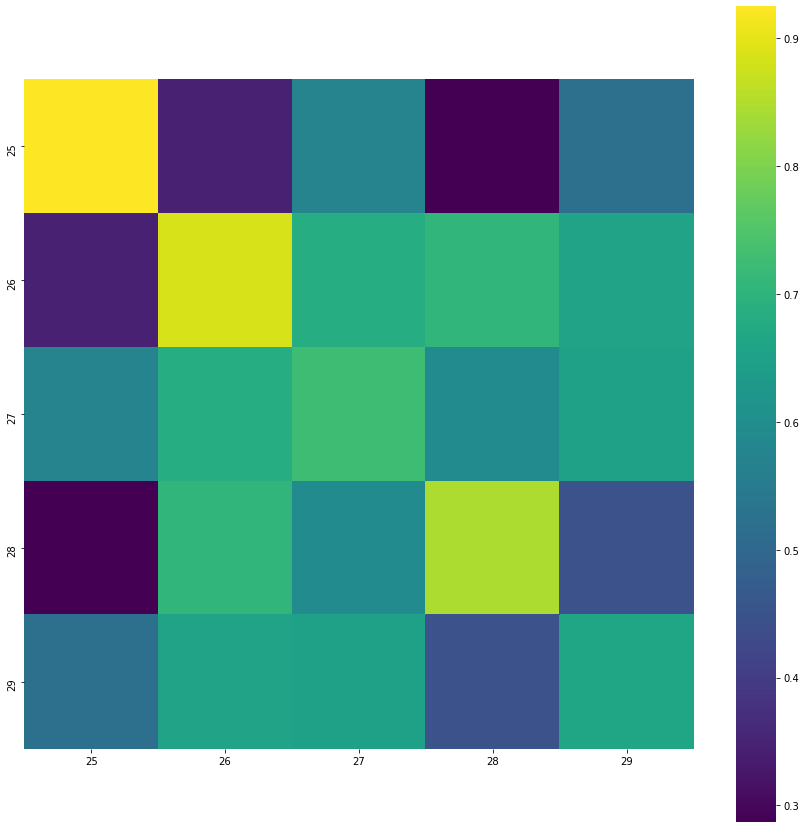

In [23]:
simi_test = plot_heatmap(val_embeddings_baseline, val_labels_baseline, dist_method="cosine")

In [24]:
# Plot average similarity within same-user vs between different users
intra_vs_inter_avg_similarity(simi_test.values)

(0.8100450975341605, 0.5460134597482844)

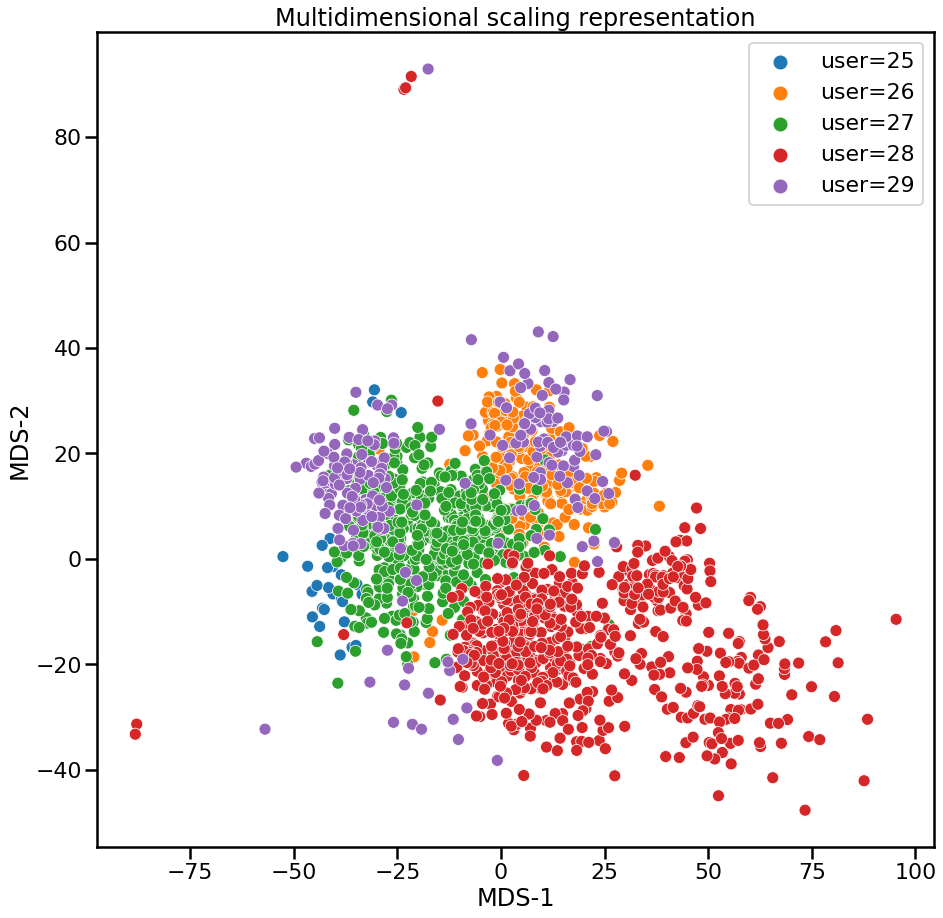

In [25]:
sns.set_context("poster")
mds_fit = plot_embeddings_mds(val_embeddings_baseline, val_labels_baseline)

In [27]:
# Save model
torch.save(embedding_net.state_dict(), "../models/Classification-Trained_EmbeddingNet.pt")